# Char Level RNN Classification

In this notebook, we will use RNN to do classifications

### Data Acquisition and Preprocessing

In [8]:
from utils import download_file_from_url,extract_zip

download_file_from_url("https://download.pytorch.org/tutorial/data.zip","./name-data.zip")
extract_zip("./name-data.zip","./data/name-data",remove_zip=True)
# I also added Turkish.txt to data/name-data 
# from https://gist.github.com/yasinkuyu/c5d18a3c2221f6ac75dc0b8fd81317e9

name-data.zip: 100%|██████████| 2.75M/2.75M [00:00<00:00, 4.62MB/s]
Extracting name-data.zip: 100%|██████████| 21/21 [00:00<00:00, 982.31files/s]


'/Users/huseyin/Codes/jarvis.dl/data/name-data/data'

In [2]:
import os
names_folder_path = './data/name-data/data/names'

data = {}
for filename in os.listdir(names_folder_path):
    # Get the full path
    full_path = os.path.join(names_folder_path, filename)
    country = filename.split('.')[0]
    with open(full_path, 'r') as f:
        lines = f.readlines()
    data[country] = [name.strip() for name in lines]        


In [3]:
# We need to convert dataset to torch dataset
classes = list(data.keys())
class_idx = {classes[i]:i for i in range(len(classes))}
idx_class = {i:classes[i] for i in range(len(classes))}


import string
import unicodedata

# Let's define vocabulary we will use char-rnn
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [4]:
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [5]:
# Dataset Implementation
# Dataset must implement three functions: __init__, __len__, and __getitem__
from torch.utils.data import Dataset
import torch
class NamesDataset(Dataset):
    def __init__(self, data, label_to_idx):
        # Data is a dictionary of country names and their corresponding names
        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []
        
        for country, names in data.items():
            for name in names:
                self.data.append(name)
                self.labels.append(country)
                self.data_tensors.append(lineToTensor(name))
                self.labels_tensors.append(torch.tensor(label_to_idx[country]))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data_tensors[idx], self.labels_tensors[idx], self.data[idx], self.labels[idx]

In [6]:
alldata = NamesDataset(data, class_idx)
alldata[0]

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]]]),
 tensor(0),
 'Abl',
 'Czech')

In [7]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator().manual_seed(2024))
len(train_set), len(test_set)

(17438, 3077)

In [8]:
class CharRNN(torch.nn.Module):
    def __init__(self,inp_size,hidden_size,out_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNN(inp_size,hidden_size)
        self.linear = torch.nn.Linear(hidden_size,out_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, line_tensor):
        output, hidden = self.rnn(line_tensor)
        output = self.linear(hidden[0])
        output = self.softmax(output)
        return output, hidden

In [46]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(data.keys()))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (linear): Linear(in_features=128, out_features=19, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [47]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

def convert_label_to_tensor(label,category_length):
    tensor = torch.zeros(category_length)
    tensor[label] = 1
    return tensor
    


input = lineToTensor('Albert')
print(input.shape)
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output[0], list(data.keys())))

torch.Size([6, 1, 58])
(tensor([[-2.9137, -2.8409, -2.9808, -2.9367, -2.8428, -2.9651, -2.9290, -3.0016,
         -2.9410, -3.0219, -3.0769, -2.8811, -3.0074, -2.9561, -2.8385, -2.9932,
         -2.9992, -2.9468, -2.9100]], grad_fn=<LogSoftmaxBackward0>), tensor([[[ 0.1222,  0.1395,  0.1502, -0.0424,  0.1295, -0.0385, -0.1260,
          -0.1026, -0.0220, -0.0009, -0.0985,  0.0207,  0.0450, -0.0528,
           0.0259, -0.1708,  0.0507,  0.0206,  0.0291,  0.0108,  0.1357,
           0.0140, -0.0432, -0.0916, -0.1802, -0.0988, -0.0541, -0.0517,
           0.0737, -0.0044,  0.1028, -0.0668, -0.2407, -0.0168,  0.0756,
           0.0648, -0.1782,  0.0578, -0.0288,  0.0089,  0.0276, -0.0617,
          -0.0236,  0.1107,  0.0146, -0.0689,  0.0842, -0.0163,  0.0178,
          -0.2560,  0.1151,  0.0160,  0.0430, -0.0773, -0.0107, -0.0627,
          -0.2107, -0.0373,  0.1636, -0.0243,  0.0073, -0.0098,  0.0923,
          -0.0138,  0.1100, -0.0994, -0.0450, -0.0623,  0.0298, -0.0561,
          -0.0

In [48]:
import numpy as np
from tqdm import tqdm

def train(rnn,
          dataset,
          criterion=torch.nn.NLLLoss(),   # 1. NLLLoss matches LogSoftmax
          n_epoch=10,
          lr=0.01,
          batch_size=64):

    optimizer = torch.optim.SGD(rnn.parameters(), lr)
    all_losses = []

    rnn.train()
    for epoch in tqdm(range(1, n_epoch + 1)):
        # shuffle indices each epoch
        indices = torch.randperm(len(dataset))
        batches = indices.split(batch_size)

        epoch_loss = 0.0
        for batch in batches:
            optimizer.zero_grad()

            batch_loss = 0.0          # numeric, for logging
            accum_loss = 0.0          # tensor, keeps graph

            for idx in batch:
                data_tensor, label_tensor, *_ = dataset[idx]
                output, _ = rnn(data_tensor)
                loss = criterion(output, label_tensor.view(1))   # 5.
                accum_loss += loss           # tensor
                batch_loss += loss.item()    # number

            accum_loss.backward()            # 2.
            torch.nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()

            epoch_loss += batch_loss

        avg_loss = epoch_loss / len(dataset)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch} – avg loss: {avg_loss:.4f}")

    return all_losses
        


In [49]:
import time
start = time.time()
all_losses = train(rnn, train_set,n_epoch=27,lr=0.15)
end = time.time()
print(f"training took {end-start}s")

  4%|▎         | 1/27 [00:04<01:52,  4.31s/it]

Epoch 1 – avg loss: 1.4647


  7%|▋         | 2/27 [00:08<01:42,  4.12s/it]

Epoch 2 – avg loss: 1.1601


 11%|█         | 3/27 [00:12<01:37,  4.05s/it]

Epoch 3 – avg loss: 1.0629


 15%|█▍        | 4/27 [00:16<01:32,  4.02s/it]

Epoch 4 – avg loss: 0.9965


 19%|█▊        | 5/27 [00:20<01:27,  3.98s/it]

Epoch 5 – avg loss: 0.9333


 22%|██▏       | 6/27 [00:24<01:23,  3.96s/it]

Epoch 6 – avg loss: 0.8858


 26%|██▌       | 7/27 [00:28<01:19,  3.95s/it]

Epoch 7 – avg loss: 0.8423


 30%|██▉       | 8/27 [00:31<01:15,  3.95s/it]

Epoch 8 – avg loss: 0.8026


 33%|███▎      | 9/27 [00:35<01:11,  3.97s/it]

Epoch 9 – avg loss: 0.7672


 37%|███▋      | 10/27 [00:39<01:07,  3.98s/it]

Epoch 10 – avg loss: 0.7370


 41%|████      | 11/27 [00:43<01:03,  3.97s/it]

Epoch 11 – avg loss: 0.7091


 44%|████▍     | 12/27 [00:47<00:59,  3.97s/it]

Epoch 12 – avg loss: 0.6854


 48%|████▊     | 13/27 [00:51<00:55,  3.96s/it]

Epoch 13 – avg loss: 0.6602


 52%|█████▏    | 14/27 [00:55<00:51,  3.98s/it]

Epoch 14 – avg loss: 0.6318


 56%|█████▌    | 15/27 [00:59<00:47,  3.98s/it]

Epoch 15 – avg loss: 0.6128


 59%|█████▉    | 16/27 [01:03<00:44,  4.00s/it]

Epoch 16 – avg loss: 0.5947


 63%|██████▎   | 17/27 [01:07<00:39,  4.00s/it]

Epoch 17 – avg loss: 0.5735


 67%|██████▋   | 18/27 [01:11<00:35,  3.99s/it]

Epoch 18 – avg loss: 0.5558


 70%|███████   | 19/27 [01:16<00:32,  4.04s/it]

Epoch 19 – avg loss: 0.5396


 74%|███████▍  | 20/27 [01:20<00:28,  4.06s/it]

Epoch 20 – avg loss: 0.5282


 78%|███████▊  | 21/27 [01:24<00:24,  4.03s/it]

Epoch 21 – avg loss: 0.5131


 81%|████████▏ | 22/27 [01:28<00:20,  4.00s/it]

Epoch 22 – avg loss: 0.4968


 85%|████████▌ | 23/27 [01:31<00:15,  3.98s/it]

Epoch 23 – avg loss: 0.4858


 89%|████████▉ | 24/27 [01:35<00:11,  3.96s/it]

Epoch 24 – avg loss: 0.4762


 93%|█████████▎| 25/27 [01:39<00:07,  3.94s/it]

Epoch 25 – avg loss: 0.4655


 96%|█████████▋| 26/27 [01:43<00:03,  3.94s/it]

Epoch 26 – avg loss: 0.4600


100%|██████████| 27/27 [01:47<00:00,  3.99s/it]

Epoch 27 – avg loss: 0.4527
training took 107.64321517944336s


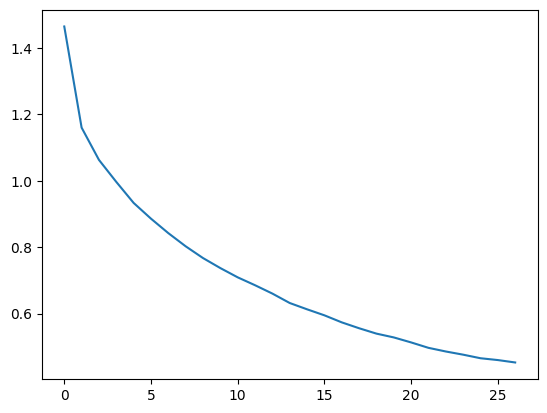

In [50]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

In [ ]:
def evaluate(rnn, test_set):

    confusion = torch.zeros(len(classes), len(classes))
    rnn.eval()
    with torch.no_grad():

        for i in range(len(test_set)):
            data_tensor, label_tensor, _ = test_set[i]
            output, _ = rnn(data_tensor)
            _,guess_i = label_from_output(output[0], list(data.keys()))
            label_i = label_tensor.item()
            confusion[guess_i][label_i] += 1
    
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()


        